# 1. 기본 설정
## (1) 라이브러리 

In [27]:
import time
start_time = time.time()

import os
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import tensorflow_datasets as tfds
import pandas as pd

print(tf.__version__)
print(np.__version__)

2.7.0
1.22.2


## (2) 파라미터 설정

In [2]:
IMG_SIZE = 32 # 리사이징할 이미지의 크기
BATCH_SIZE = 32
EPOCH = 50

initial_learning_rate = 1e-4
decay_steps = 5
decay_rate = 1e-5
decay_optimizer=SGD(learning_rate=
              ExponentialDecay(
                  initial_learning_rate = initial_learning_rate,
                  decay_steps=decay_steps,
                  decay_rate=decay_rate), clipnorm=1.)
constant_optimizer=SGD(lr=initial_learning_rate, clipnorm=1.)

optimizer = constant_optimizer

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


# 2. 데이터 전처리
## (1) 데이터 로드 및 기본사항 확인

In [3]:
# 데이터 로드
# (raw_train, raw_validation, raw_test), ds_info = tfds.load(
(raw_train, raw_test), ds_info = tfds.load(
    'cats_vs_dogs',
#     split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files = True,
    with_info=True,
    as_supervised=True,
)



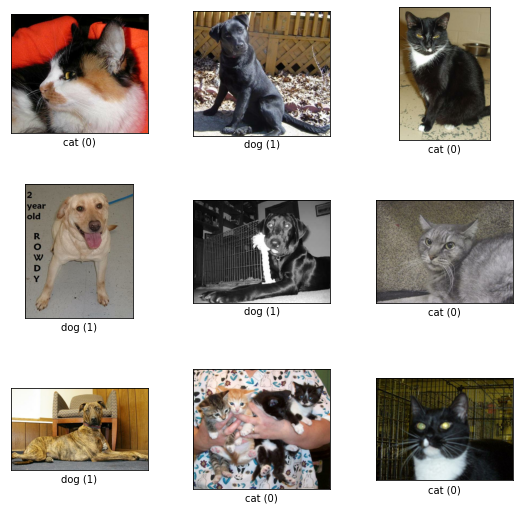

In [4]:
# 샘플 이미지 확인 - Train set
fig = tfds.show_examples(raw_train, ds_info)

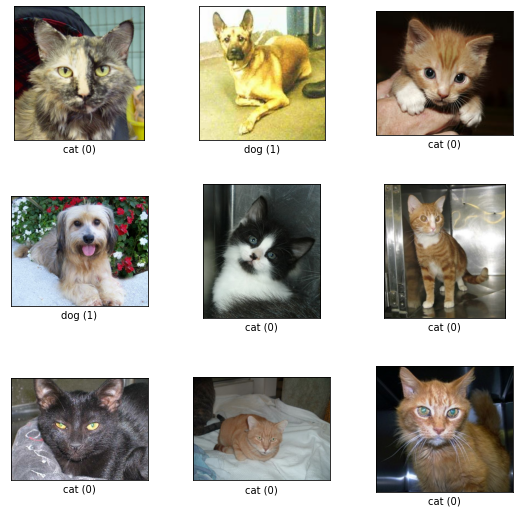

In [5]:
# 샘플 이미지 확인 - Test set
fig = tfds.show_examples(raw_test, ds_info)

## (2) 전처리

In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# def format_example(image, label):
#     image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
#     image = (image/127.5) - 1 # 픽셀값의 scale 수정
#     image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
#     return image, label

In [7]:

# ds_train = raw_train.map(format_example)
# ds_validation = raw_validation.map(format_example)
# ds_test = raw_test.map(format_example)

ds_train = apply_normalize_on_dataset(raw_train, batch_size=BATCH_SIZE)
# ds_validation = apply_normalize_on_dataset(raw_validation, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(raw_test, batch_size=BATCH_SIZE)

print(ds_train)
# print(ds_validation)
print(ds_test)

<PrefetchDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.float32, tf.int64)>


In [8]:
# # Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [9]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(-1, shape=(), dtype=int64)
tf.Tensor(-1, shape=(), dtype=int64)


In [10]:
ds_info.features["label"].num_classes

2

In [11]:
ds_info.features["label"].names

['cat', 'dog']

# 3. Resnet 모델 제작
## (1) Resnet block

In [12]:
# is_50 : True --> resnet_50
# is_plain :True --> no skip connection    
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):
    # 입력 레이어
    x = input_layer
    if not is_50:
    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
                # skip connection
                x = keras.layers.Add()([x,identity])   
            else:
                pass
    else :
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}'
        )(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]    

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
            # skip connection
            x = keras.layers.Add()([x,identity])   
        else:
            pass
    #     Max Pooling 레이어
    # 마지막 블록 뒤에는 pooling을 하지 않음
    if identity.shape[1] != 1:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x

## (2) Resnet builder

In [13]:
def build_resnet(input_shape=(IMG_SIZE,IMG_SIZE,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
#               save_every,
              num_classes=10,is_50 = False, is_plain = False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 10
        
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = keras.layers.Conv2D(filters=64,
                       kernel_size = (2,2),
                       strides = 2,
                         padding = 'valid')(output)
    output = keras.layers.BatchNormalization()(output)
    
    #conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2,)(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )    
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)    
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
#     # 체크 포인트 저장
#         if (epoch +1) % save_every == 0:
#             checkpoint.save(file_prefix = checkpoint_prefix)
    return model

## (3) 세부 타입 별 모델 설정

In [14]:
plain_resnet_34 = build_resnet(is_50 = False, is_plain = True)
plain_resnet_50 = build_resnet(is_50 = True, is_plain = True)

resnet_34 = build_resnet(is_50 = False)
resnet_50 = build_resnet(is_50 = True)


# 4. 네트워크 운영 및 결과 분석

## (1) Resnet-34 운영

In [16]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
581/581 [==============================] - 46s 70ms/step - loss: 1.4631 - accuracy: 0.4060 - val_loss: 0.8314 - val_accuracy: 0.5076
Epoch 2/50
581/581 [==============================] - 41s 71ms/step - loss: 0.8371 - accuracy: 0.5271 - val_loss: 0.8219 - val_accuracy: 0.5372
Epoch 3/50
581/581 [==============================] - 38s 65ms/step - loss: 0.7816 - accuracy: 0.5441 - val_loss: 0.7762 - val_accuracy: 0.5608
Epoch 4/50
581/581 [==============================] - 42s 72ms/step - loss: 0.7538 - accuracy: 0.5705 - val_loss: 0.7711 - val_accuracy: 0.5716
Epoch 5/50
581/581 [==============================] - 40s 69ms/step - loss: 0.7328 - accuracy: 0.5797 - val_loss: 0.7532 - val_accuracy: 0.5682
Epoch 6/50
581/581 [==============================] - 39s 67ms/step - loss: 0.7098 - accuracy: 0.5938 - val_loss: 0.7183 - val_accuracy: 0.6129
Epoch 7/50
581/581 [==============================] - 39s 67ms/step - loss: 0.7008 - accuracy: 0.5997 - val_loss: 0.7302 - val_accuracy:

## (2) Plain Resnet-34 운영

In [17]:
plain_resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer, 
    metrics=['accuracy'],
)

plain_history_34 = plain_resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
581/581 [==============================] - 42s 66ms/step - loss: 1.5550 - accuracy: 0.3931 - val_loss: 0.8807 - val_accuracy: 0.5085
Epoch 2/50
581/581 [==============================] - 38s 65ms/step - loss: 0.8891 - accuracy: 0.5213 - val_loss: 0.8606 - val_accuracy: 0.5259
Epoch 3/50
581/581 [==============================] - 37s 64ms/step - loss: 0.8309 - accuracy: 0.5468 - val_loss: 0.8271 - val_accuracy: 0.5386
Epoch 4/50
581/581 [==============================] - 37s 64ms/step - loss: 0.7992 - accuracy: 0.5592 - val_loss: 0.8048 - val_accuracy: 0.5641
Epoch 5/50
581/581 [==============================] - 38s 65ms/step - loss: 0.7669 - accuracy: 0.5708 - val_loss: 0.8027 - val_accuracy: 0.5623
Epoch 6/50
581/581 [==============================] - 39s 67ms/step - loss: 0.7592 - accuracy: 0.5778 - val_loss: 0.7815 - val_accuracy: 0.5658
Epoch 7/50
581/581 [==============================] - 37s 64ms/step - loss: 0.7374 - accuracy: 0.5870 - val_loss: 0.7577 - val_accuracy:

## (3) Resnet 50 운영

In [18]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer, 
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
581/581 [==============================] - 42s 66ms/step - loss: 2.4940 - accuracy: 0.3454 - val_loss: 0.8828 - val_accuracy: 0.5041
Epoch 2/50
581/581 [==============================] - 38s 65ms/step - loss: 0.8642 - accuracy: 0.5164 - val_loss: 0.8481 - val_accuracy: 0.5297
Epoch 3/50
581/581 [==============================] - 38s 65ms/step - loss: 0.8018 - accuracy: 0.5420 - val_loss: 0.8110 - val_accuracy: 0.5537
Epoch 4/50
581/581 [==============================] - 38s 66ms/step - loss: 0.7704 - accuracy: 0.5633 - val_loss: 0.7973 - val_accuracy: 0.5494
Epoch 5/50
581/581 [==============================] - 38s 66ms/step - loss: 0.7492 - accuracy: 0.5708 - val_loss: 0.7661 - val_accuracy: 0.5668
Epoch 6/50
581/581 [==============================] - 38s 65ms/step - loss: 0.7309 - accuracy: 0.5854 - val_loss: 0.7576 - val_accuracy: 0.5760
Epoch 7/50
581/581 [==============================] - 38s 65ms/step - loss: 0.7133 - accuracy: 0.5941 - val_loss: 0.7396 - val_accuracy:

## (4) Plain Resnet-50 운영

In [19]:
plain_resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer, 
    metrics=['accuracy'],
)

plain_history_50 = plain_resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
581/581 [==============================] - 43s 68ms/step - loss: 1.4621 - accuracy: 0.5022 - val_loss: 0.7765 - val_accuracy: 0.5439
Epoch 2/50
581/581 [==============================] - 40s 68ms/step - loss: 0.7645 - accuracy: 0.5629 - val_loss: 0.7643 - val_accuracy: 0.5741
Epoch 3/50
581/581 [==============================] - 40s 68ms/step - loss: 0.7402 - accuracy: 0.5780 - val_loss: 0.7416 - val_accuracy: 0.5821
Epoch 4/50
581/581 [==============================] - 40s 68ms/step - loss: 0.7187 - accuracy: 0.5861 - val_loss: 0.7320 - val_accuracy: 0.5858
Epoch 5/50
581/581 [==============================] - 40s 68ms/step - loss: 0.7047 - accuracy: 0.5969 - val_loss: 0.7260 - val_accuracy: 0.5864
Epoch 6/50
581/581 [==============================] - 40s 68ms/step - loss: 0.6903 - accuracy: 0.6083 - val_loss: 0.7207 - val_accuracy: 0.5883
Epoch 7/50
581/581 [==============================] - 40s 68ms/step - loss: 0.6820 - accuracy: 0.6164 - val_loss: 0.6932 - val_accuracy:

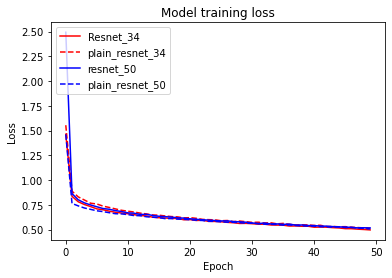

In [20]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'r')
plt.plot(plain_history_34.history['loss'], 'r--')
plt.plot(history_50.history['loss'], 'b')
plt.plot(plain_history_50.history['loss'], 'b--')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Resnet_34', 'plain_resnet_34', 'resnet_50', 'plain_resnet_50'], loc='upper left')
plt.show()

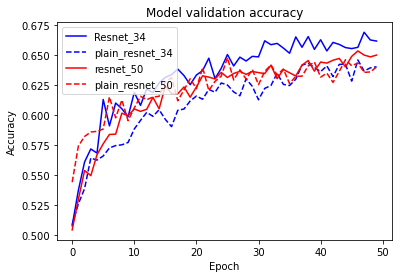

In [21]:
# 그리고 검증 정확도(validation accuracy)를 비교해 봅시다.
plt.plot(history_34.history['val_accuracy'], 'b')
plt.plot(plain_history_34.history['val_accuracy'], 'b--')
plt.plot(history_50.history['val_accuracy'], 'r')
plt.plot(plain_history_50.history['val_accuracy'], 'r--')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Resnet_34', 'plain_resnet_34', 'resnet_50', 'plain_resnet_50'], loc='upper left')
plt.show()

In [34]:
final_acc=[]
final_acc.append(round(history_34.history['val_accuracy'][-1],4))
final_acc.append(round(plain_history_34.history['val_accuracy'][-1],4))
final_acc.append(round(history_50.history['val_accuracy'][-1],4))
final_acc.append(round(plain_history_50.history['val_accuracy'][-1],4))

df_final_acc = pd.DataFrame(final_acc)
df_final_acc.rename(index = {0: 'ResNet-34', 1: 'Plain ResNet-34', 
                            2: 'ResNet-50', 3: 'Plain ResNet-50'}, 
                   columns = {0: 'Final Val. acc'}, inplace = True)
df_final_acc

,Final Val. acc
ResNet-34,0.6617
Plain ResNet-34,0.6403
ResNet-50,0.6500
Plain ResNet-50,0.6401


In [22]:
end_time = time.time()
work_time = int((end_time - start_time)//60)

print("총 작업시간: 약 {}분".format(work_time))
print("***모든 작업 완료***")

총 작업시간: 약 129분
***모든 작업 완료***


# 회고
- 바꿀 수 있는 옵션이 많지 않아, Batch size, Learning rate, Epoch 등만 이리저리 조절해 보았다. 
- 각 모델의 plain 버전은 원본 버전보다 결과값(final validation accuracy)이 더 낮게 나왔다.
- ResNet-34의 결과값이 ResNet-50의 결과값보다 여기서는 더 높았고, 이전의 다른 결과들에서는 비슷하게 나왔다.
- 50epoch 당 소요시간은 약 2시간이어서, 현재 세팅에서의 결과 정도로 만족하고 제출한다.

# 마침